# Feature Extracting Using CellProfiler
## https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_cellprofiler.html

In [ ]:
# !micromamba create -y -n feature_extraction
# !micromamba activate feature_extraction

## Import packages and data

In [16]:
import itertools
from pathlib import Path

from PIL import Image # type: ignore

import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
sc.set_figure_params(facecolor="white", figsize=(8, 8))

# load the pre-processed dataset
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13
squidpy==1.5.0


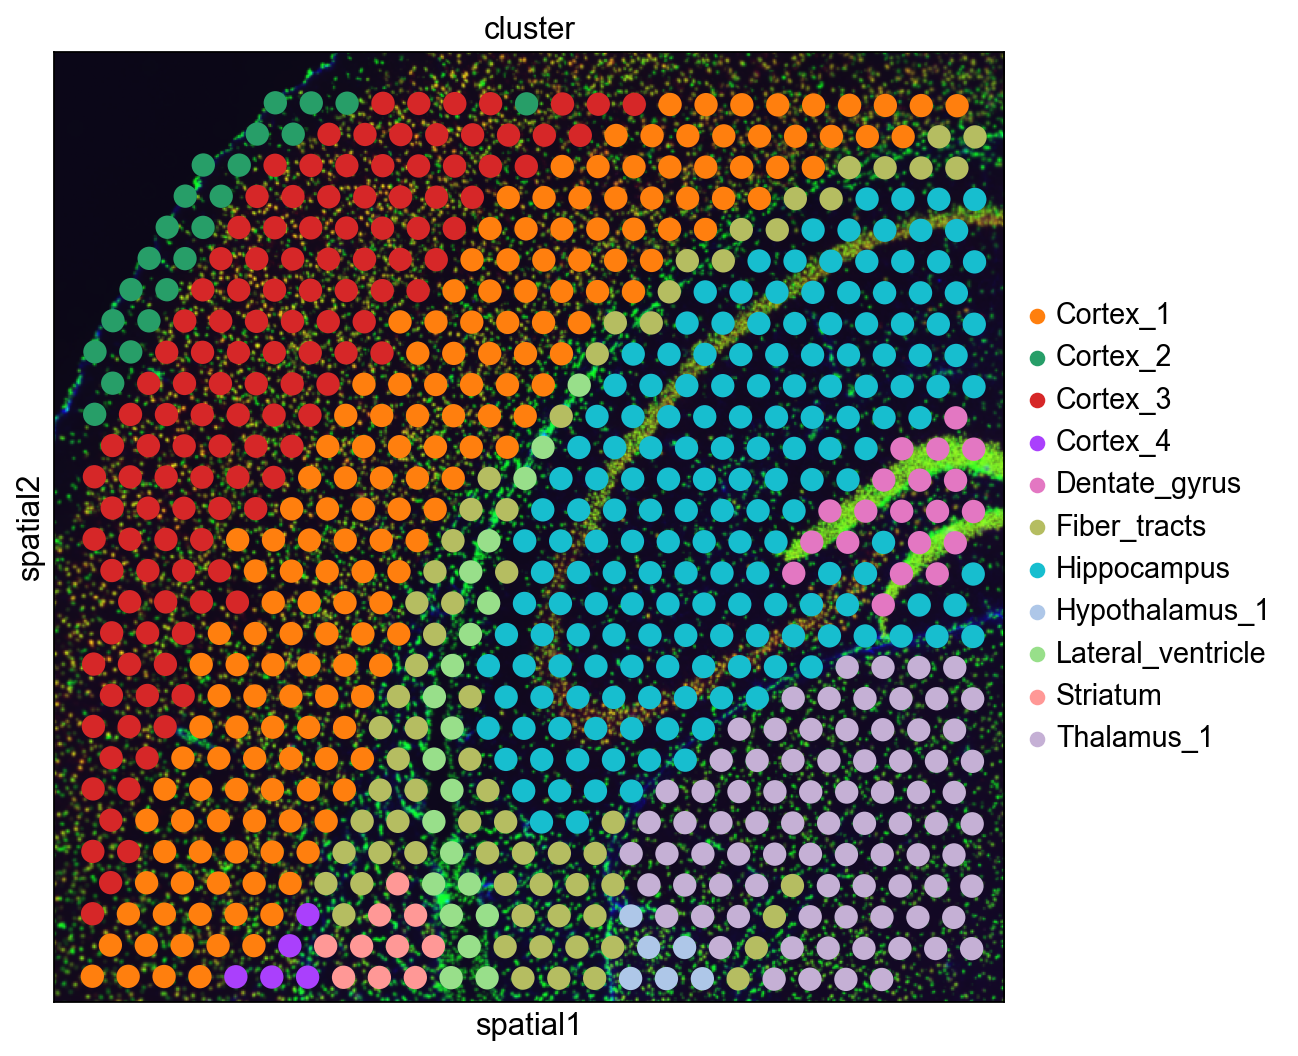

In [3]:
sq.pl.spatial_scatter(adata, color="cluster")

### Setup file hierarchy

In [4]:
BASE_DIR = "./"
imgs = BASE_DIR + "tmp_imgs/"
Path(imgs).mkdir(parents=True, exist_ok=True)

### Image segmentation

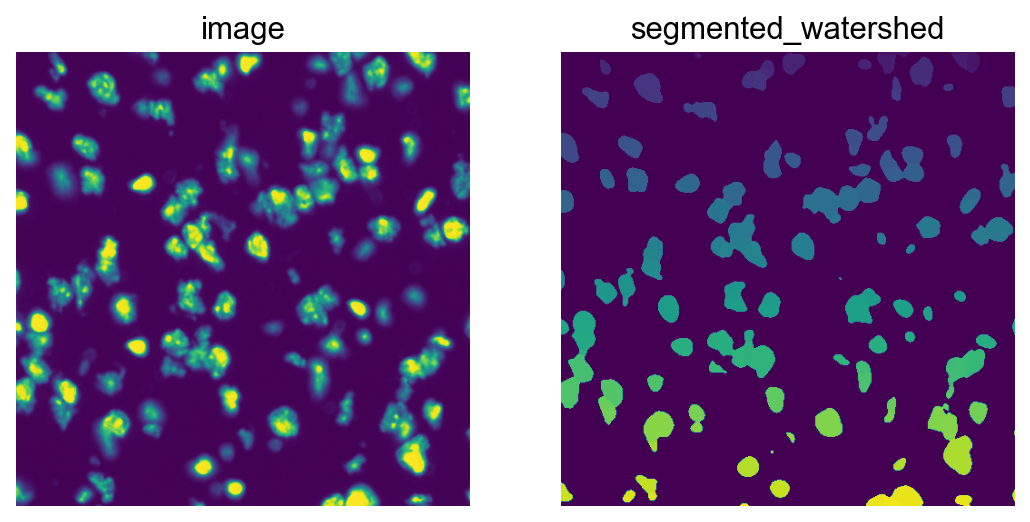

In [8]:
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
    sigma=[2, 2, 0, 0],
)

sq.im.segment(
    img=img, layer="image_smooth", method="watershed", channel_ids=0, chunks=1000
)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(2000, 2000, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

### Save image crops and segmentations

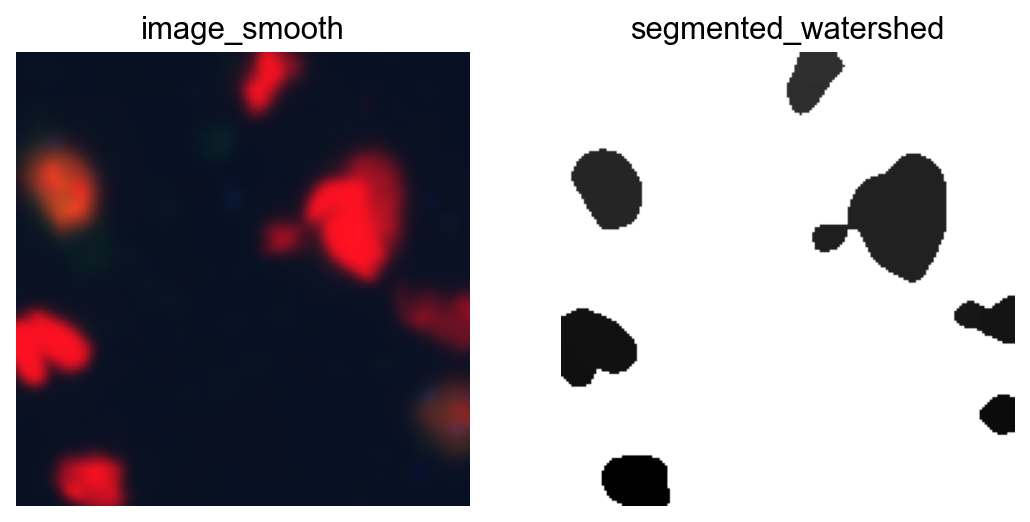

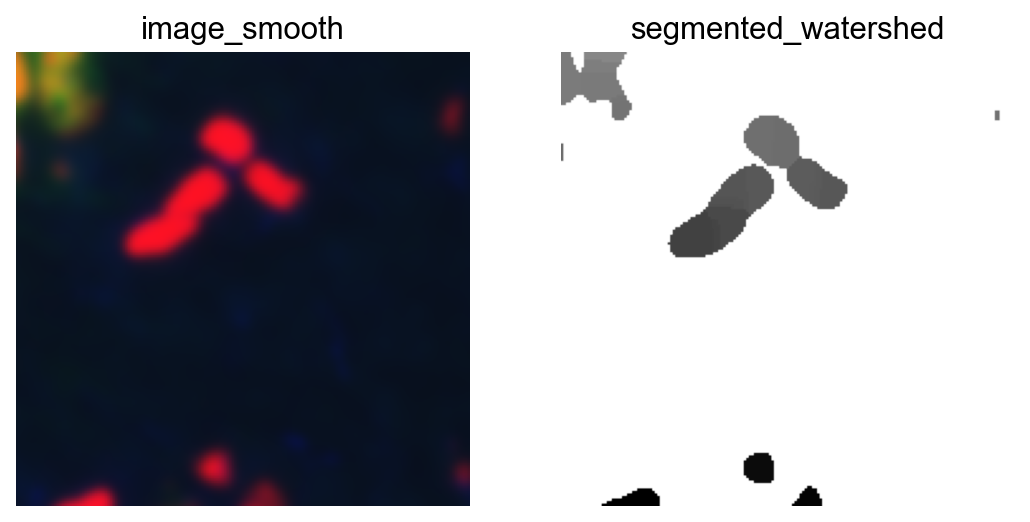

In [9]:
for crop, obs in itertools.islice(
    img.generate_spot_crops(
        adata, obs_names=adata.obs_names, return_obs=True, as_array=False
    ),
    2,
):
    fig, axes = plt.subplots(1, 2)
    crop.show("image_smooth", ax=axes[0])
    crop.show("segmented_watershed", ax=axes[1], cmap="Greys")
    plt.show()

In [10]:
for crop, obs in img.generate_spot_crops(
    adata, obs_names=adata.obs_names, return_obs=True, as_array=False
):
    Image.fromarray(
        (np.array(crop["image_smooth"]) * 255).squeeze().astype(np.uint8)
    ).save(imgs + f"image_{obs}.png")
    Image.fromarray((np.array(crop["segmented_watershed"][:, :, 0])).squeeze()).save(
        imgs + f"segments_{obs}.tif"
    )

### Calculating image features in CellProfiler

1. Create new project in CellProfiler

2.  Save project as BASE_DIR

3. CP-Pipeline Images: Drag and Drop the folder imgs into CellProfiler

4. CP-Pipeline NamesAndTypes: Declare to load crops as color images and segmentations as objects. Crops and segmentations files are aligned automatically

5. Convert image crops to gray images: Add ColorToGray module and define parameters

6. Measure CellProfiler’s Granularity features within segments for each crop: Add MeasureGranularity module and define parameters

7. Export results to csv

8. Run CellProfiler Pipeline (takes several minutes)

In [ ]:
# !rm -rf tmp_imgs
# Can delete the images in the imgs folder

## Cluster features

In [12]:
# load CellProfiler output
df = pd.read_csv(BASE_DIR + "/squidpy_Image.csv")
# set obs names as index
df.index = df["FileName_Spot_Crop"].apply(lambda s: s.split("_")[1].split(".")[0])
df.index.name = "obs"
# Get the measured Granularity features and rename them
features = [
    f"{stat}_Segments_Granularity_{i}_SpotGray"
    for stat in ["Mean", "StDev"]
    for i in range(1, 17)
]
df = df[features]
df.columns = [s.split("_")[0] + s.split("_")[2] + s.split("_")[3] for s in df.columns]

In [13]:
df.head()

MeanGranularity1  MeanGranularity2  MeanGranularity3  \
obs                                                                        
AAACGAGACGGTTGAT-1         40.809622          5.141421          2.706656   
AAAGGGATGTAGCAAG-1         55.696372          5.413312          0.828944   
AAATGGCATGTCTTGT-1         45.850881          8.505550          1.275272   
AAATGGTCAATGTGCC-1         27.994631          2.637111          0.077868   
AAATTAACGGGTAGCT-1         37.487246          4.622774          0.130100   

                    MeanGranularity4  MeanGranularity5  MeanGranularity6  \
obs                                                                        
AAACGAGACGGTTGAT-1          8.598882          3.668645          0.411101   
AAAGGGATGTAGCAAG-1          5.552738          4.466535          0.000000   
AAATGGCATGTCTTGT-1         12.805762          5.158347          7.693333   
AAATGGTCAATGTGCC-1          3.912260          0.693851          0.000000   
AAATTAACGGGTAGCT-1          1.600888          6.618194          5.274682   

                    MeanGranularity7  MeanGranularity8  MeanGranularity9  \
obs                                                                        
AAACGAGACGGTTGAT-1          1.450973          4.054359          0.000000   
AAAGGGATGTAGCAAG-1          3.462490          0.000000         15.080486   
AAATGGCATGTCTTGT-1          6.156577          1.007035          1.511579   
AAATGGTCAATGTGCC-1          0.000000          0.115668          0.000000   
AAATTAACGGGTAGCT-1          0.000000          7.268887          0.000000   

                    MeanGranularity10  ...  StDevGranularity7  \
obs                                    ...                      
AAACGAGACGGTTGAT-1           5.120530  ...           0.238227   
AAAGGGATGTAGCAAG-1           0.000000  ...           0.606106   
AAATGGCATGTCTTGT-1           0.000000  ...           0.494694   
AAATGGTCAATGTGCC-1           8.598186  ...           0.000000   
AAATTAACGGGTAGCT-1           1.628285  ...           0.000000   

                    StDevGranularity8  StDevGranularity9  StDevGranularity10  \
obs                                                                            
AAACGAGACGGTTGAT-1           0.589931           0.000000            0.657961   
AAAGGGATGTAGCAAG-1           0.000000           2.252283            0.000000   
AAATGGCATGTCTTGT-1           0.066432           0.099527            0.000000   
AAATGGTCAATGTGCC-1           0.077511           0.000000            3.973375   
AAATTAACGGGTAGCT-1           1.064200           0.000000            0.239823   

                    StDevGranularity11  StDevGranularity12  \
obs                                                          
AAACGAGACGGTTGAT-1             0.00000            0.000000   
AAAGGGATGTAGCAAG-1             0.00000            0.100719   
AAATGGCATGTCTTGT-1             0.00000            0.253942   
AAATGGTCAATGTGCC-1             1.40506            0.000000   
AAATTAACGGGTAGCT-1             0.00000            0.000000   

                    StDevGranularity13  StDevGranularity14  \
obs                                                          
AAACGAGACGGTTGAT-1            0.062373            0.609213   
AAAGGGATGTAGCAAG-1            0.191596            0.000000   
AAATGGCATGTCTTGT-1            0.067690            0.000000   
AAATGGTCAATGTGCC-1            1.377994            0.000000   
AAATTAACGGGTAGCT-1            0.740413            0.842695   

                    StDevGranularity15  StDevGranularity16  
obs                                                         
AAACGAGACGGTTGAT-1            0.000000            1.248567  
AAAGGGATGTAGCAAG-1            0.000000            0.138406  
AAATGGCATGTCTTGT-1            0.000000            0.201406  
AAATGGTCAATGTGCC-1            1.391238            0.000000  
AAATTAACGGGTAGCT-1            0.232786            0.406238  

[5 rows x 32 columns]

C:\Users\andrew\AppData\Local\Temp\ipykernel_21816\3358988062.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


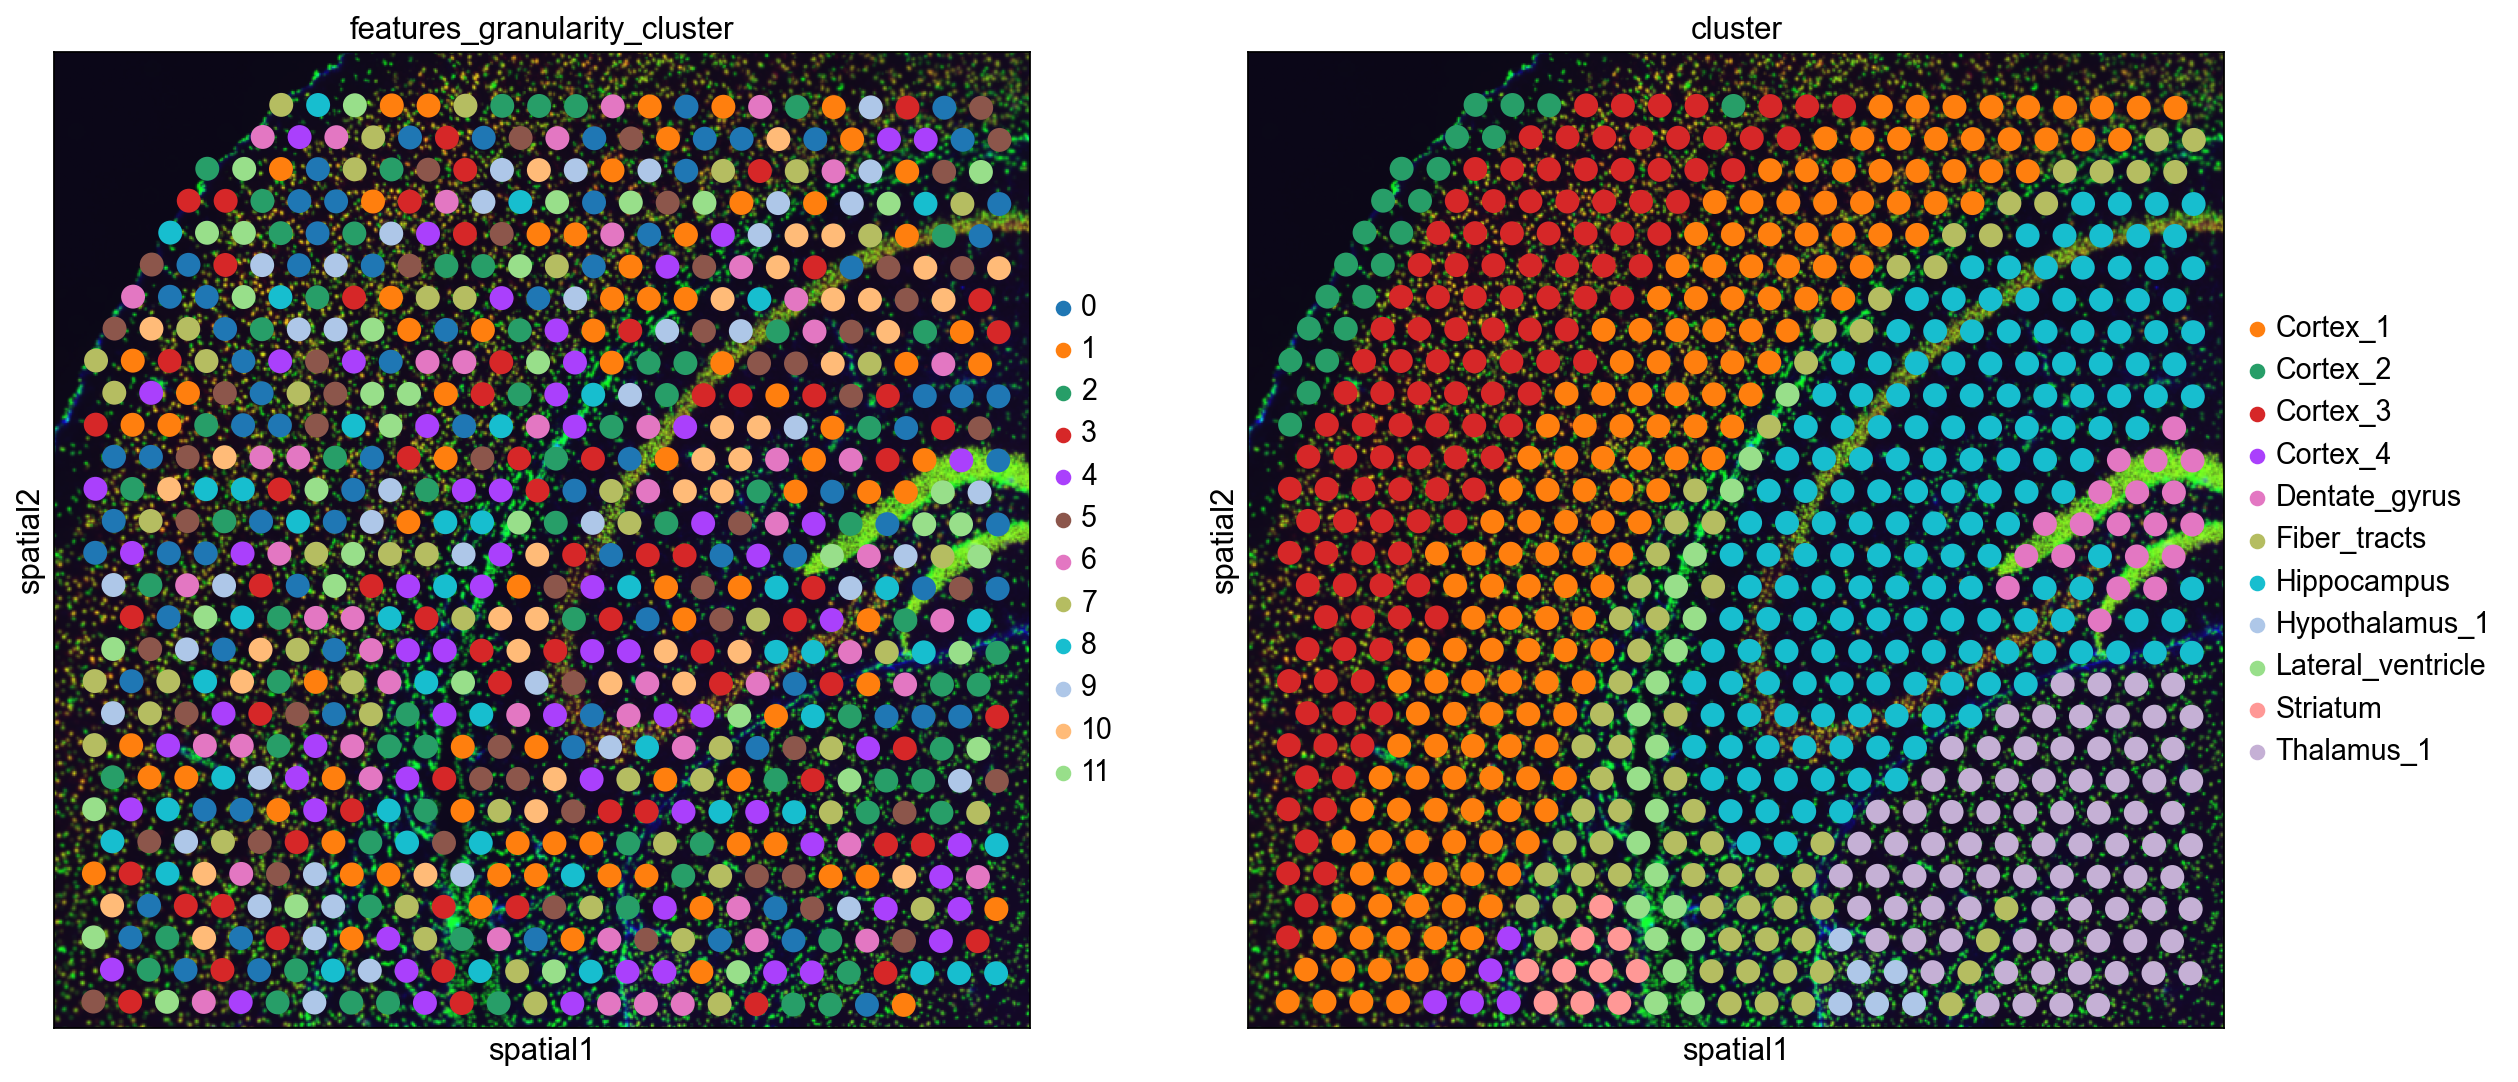

In [18]:
def cluster_features(features: pd.DataFrame):
    """Calculate leiden clustering of features."""
    # Impute missing values with the mean of each column
    imputer = SimpleImputer(strategy='mean')
    features_imputed = imputer.fit_transform(features)
    # Create temporary adata to calculate the clustering
    adata = ad.AnnData(features_imputed, obs=features.index.to_frame())
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# Save feature in adata.obsm
adata.obsm["features"] = df.loc[adata.obs_names].copy()

# Calculate leiden clustering
adata.obs["features_granularity_cluster"] = cluster_features(adata.obsm["features"])

# Plot clusterings
sq.pl.spatial_scatter(
    adata,
    color=[
        "features_granularity_cluster",
        "cluster",
    ],
    ncols=2,
)